# MCMC Fitting the emission profile to an emission spectrum  

This example conducts HMC-NUTS fitting to a mock absorption line. We use Schwarzchild equation of the absorption model based on Tepper 
approximation of Voigt profile, lpf.FAbsVTc in exojax.lpf (line profile functions) module. 

HMC-NUTS: Hamiltonian Monte Carlo No-U-Turn Sample using numpyro

In [1]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import lpf
from exojax.spec import rtransfer as rt
from exojax.spec import planck

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap, jit
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

plt.style.use('bmh')
#numpyro.set_platform("cpu")
numpyro.set_platform("gpu")

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# generating mock absorption data
np.random.seed(38)
N=1000
nur=500
nuarr=jnp.linspace(-nur,nur,N)
sigin=0.01
sDfix = jnp.array(1.0)
gLfix = jnp.array(0.5)

Nmol=1000
hatnufix = (np.random.rand(Nmol)-0.5)*nur*2
Sfix=np.random.rand(Nmol)
nu0fix = 0.7
#f = lambda nu: lpf.MultiAbsVTc(nu-nu0fix,sDfix,gLfix,Afix,Sfix,hatnufix)

numatrix=lpf.make_numatrix(nuarr,hatnufix,nu0fix)
#cs=rt.cross(numatrix,sDfix,gLfix,Sfix)


In [4]:
NP=30
Parr, dParr, k=rt.const_p_layer(NP=NP)
Tarr = 1000.*(Parr/Parr[0])**-0.1

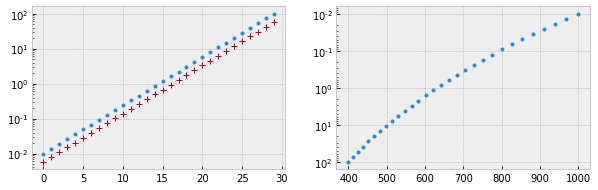

In [5]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(121)
ax.plot(Parr,".")
ax.plot(Parr/(k+1),"+")
plt.yscale("log")
ax=fig.add_subplot(122)
ax.plot(Tarr,Parr,".")
#plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()

In [7]:
#N=50
#nuarr=jnp.linspace(-10,10,N)
#nuarr=jnp.array(1.0)
@jit
def add_layer(carry,x):
    """add an atmospheric layer
    Params:
      carry: F[i], P[i], nu0, sigmaD, gammaL
      x: free parameters, T
      
    Returns:
      carry: F[i+1], P[i+1]=k*P[i]
      dtaui: dtau of this layer
    """
    F,Pi,nu0,sigmaD,gammaL = carry
    Ti = x
    numic=1.0/2.0
    #dP = k*Pi
    gi = planck.nB(Ti,numic)
    ####
    numatrix=lpf.make_numatrix(nuarr,hatnufix,nu0)
    cs=rt.cross(numatrix,sigmaD,gammaL,Sfix)
    ####
    #dtaui = 1.e-1*lpf.VoigtTc(nuarr-nu0,sigmaD,gammaL)*(1.0-k)*Pi
    dtaui = 1.e-1*cs*(1.0-k)*Pi # delta P = (1.0-k)*Pi
    Trans=(1.0-dtaui)*jnp.exp(-dtaui)
    F = F*Trans + gi*(1.0-Trans)
    carry=[F,k*Pi,nu0,sigmaD,gammaL] #carryover 
    return carry,dtaui

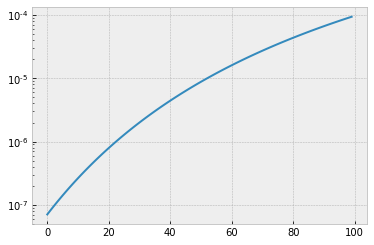

In [8]:
plt.plot(planck.nB(jnp.linspace(500,1000,100),0.5))
plt.yscale("log")

In [27]:
%timeit g(Tarr)

5.79 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
np.shape(nuarr),np.shape(numatrix)

((300,), (100, 300))

In [6]:
numic=0.5
gi = planck.nB(Tarr,numic)
dParr = (1.0-k)*Parr
nu0=0.7
sigmaD=1.0
gammaL=0.5
xsv = 1.e-1*jnp.dot((lpf.VoigtHjert(numatrix.flatten(),sigmaD,gammaL)).reshape(jnp.shape(numatrix)).T,Sfix)

In [12]:
np.shape(cs)

(300,)

In [7]:
dtauM=dParr[:,None]*xsv[None,:]
TransM=(1.0-dtauM)*jnp.exp(-dtauM)

#QN=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
QN=jnp.zeros(len(nuarr))
Qv=(1-TransM)*gi[:,None]
Qv=jnp.vstack([Qv,QN])

onev=jnp.ones(len(nuarr))

TransM=jnp.vstack([onev,TransM])
F=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
F=F*3.e7

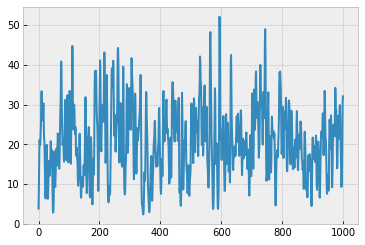

In [8]:
plt.plot(F)

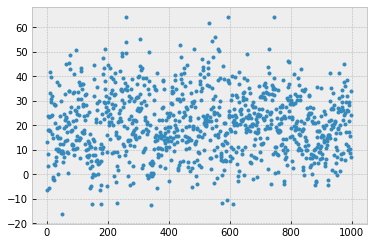

In [27]:
sigin=10.0
data=F+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [27]:
  
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    numic=0.5
    gi = planck.nB(Tarr,numic)
    numatrix=lpf.make_numatrix(nuarr,hatnufix,nu0)
    xsv = 1.e-1*jnp.dot((lpf.VoigtHjert(numatrix.flatten(),sigmaD,gammaL)).reshape(jnp.shape(numatrix)).T,Sfix)
#    xsv=1.e-1*lpf.VoigtHjert(nuarr-nu0,sD,gL)
    dtauM=dParr[:,None]*xsv[None,:]
    TransM=(1.0-dtauM)*jnp.exp(-dtauM)

    #QN=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    QN=jnp.zeros(len(nuarr))
    Qv=(1-TransM)*gi[:,None]
    Qv=jnp.vstack([Qv,QN])
    
    onev=jnp.ones(len(nuarr))
    
    TransM=jnp.vstack([onev,TransM])
    F=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    mu=F*3.e7
   
    #numic=0.5
    #nuarr=nu
    #F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #init=[F0,Parr[0],nu0,sD,gL]
    #FP,null=scan(add_layer,init,Tarr,NP)
    #mu = FP[0]*3.e4
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [21]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [01:26<00:00, 34.80it/s, 7 steps of size 3.91e-01. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.10      0.00     -0.10     -0.10     -0.10   2674.29      1.00
        gL      1.01      0.98      0.72      0.00      2.22   1789.98      1.00
       nu0      0.68      0.02      0.68      0.64      0.71   1669.40      1.00
        sD      1.01      0.98      0.70      0.00      2.35   2285.85      1.00
     sigma      0.79      0.03      0.79      0.73      0.84   1386.12      1.00

Number of divergences: 0


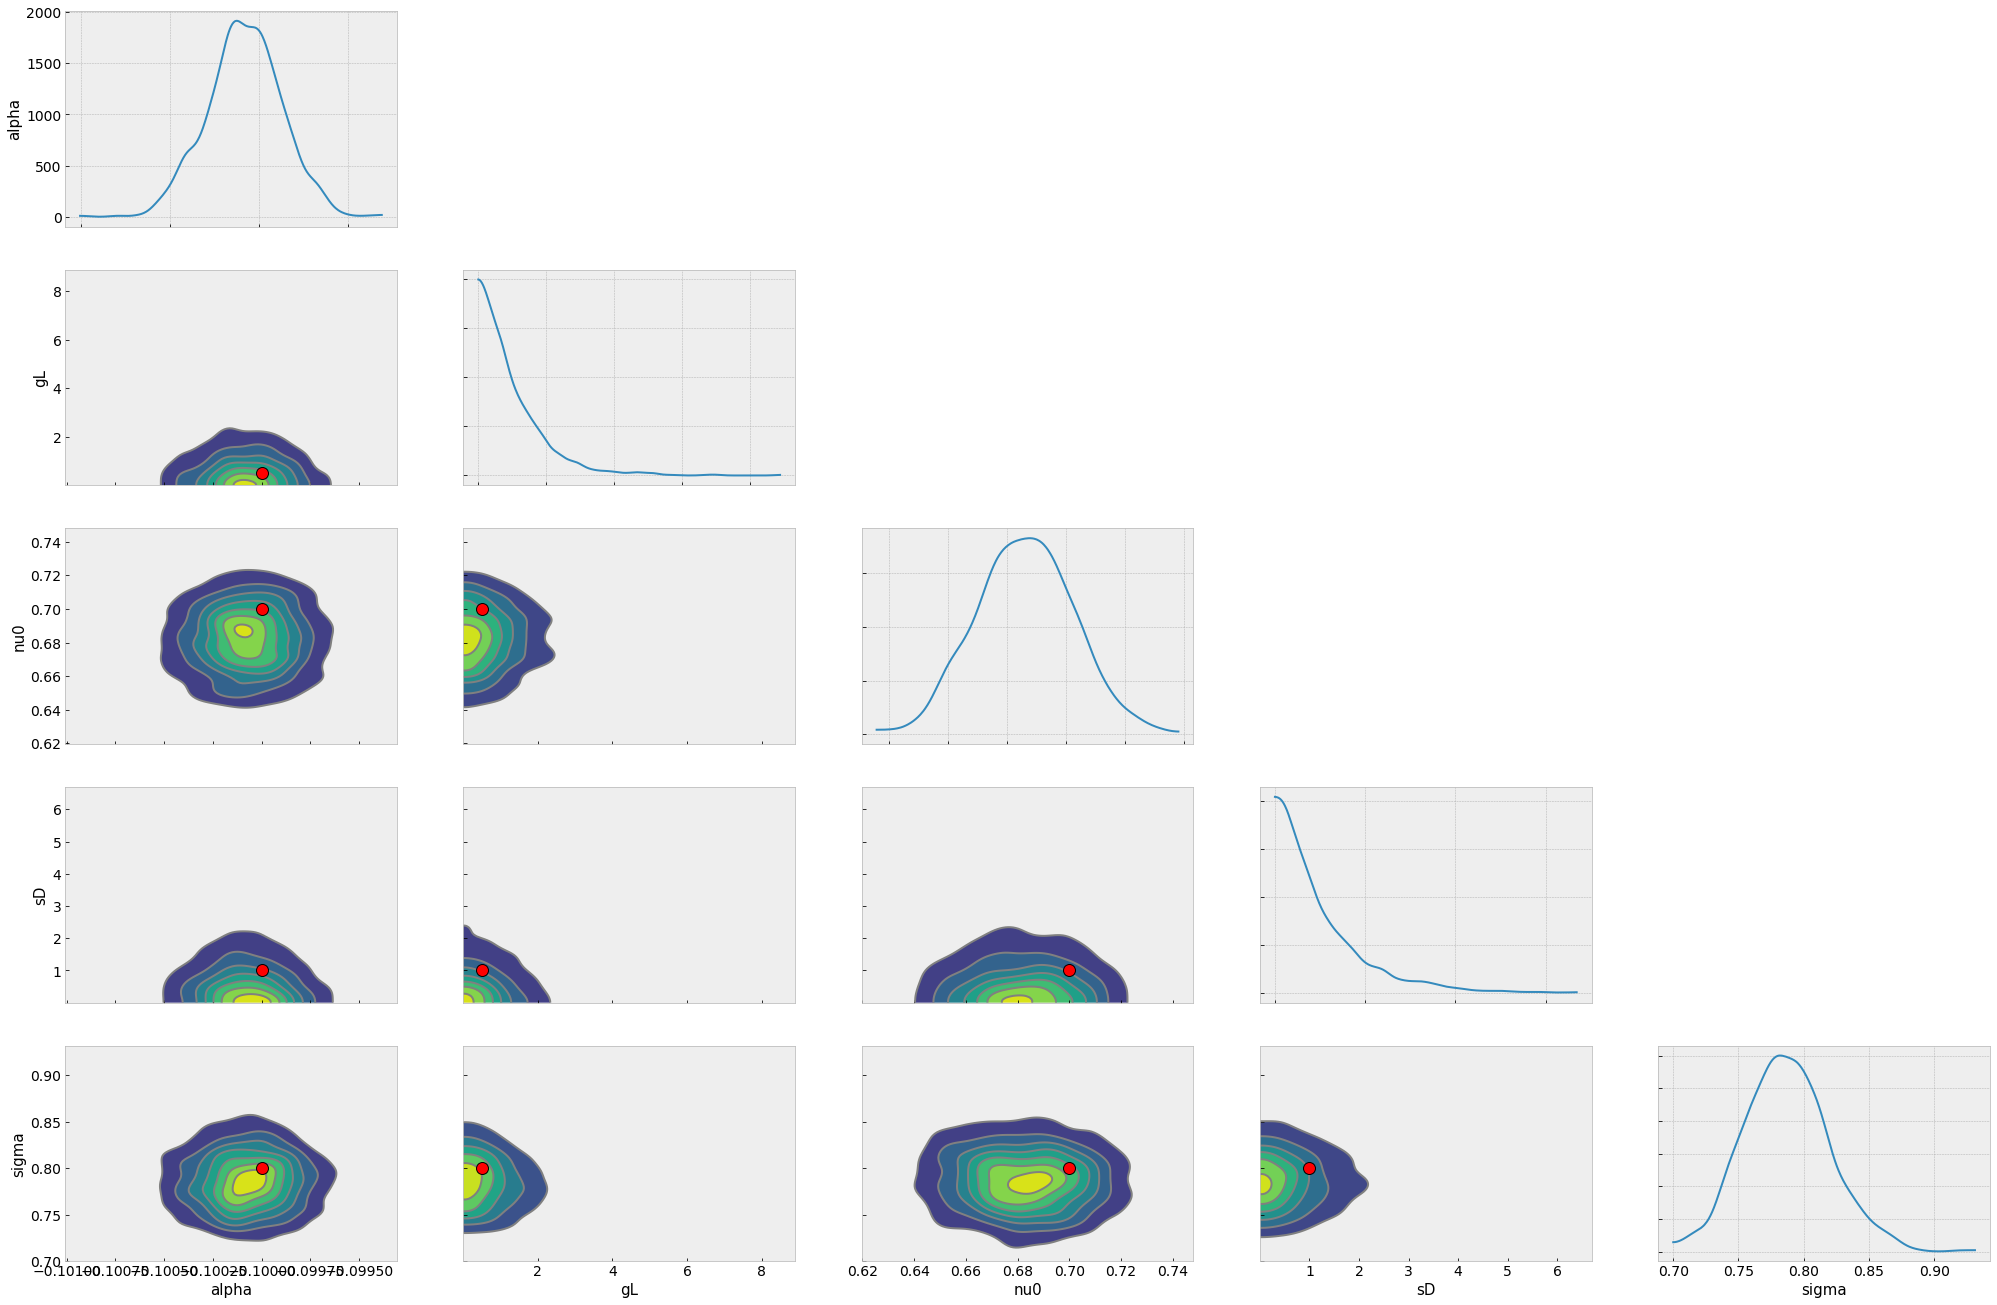

In [27]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

## LA RT (class)

In [28]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.dParr=dParr
jaxrt.NP=NP
jaxrt.k=k

In [34]:
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    source = planck.nB(Tarr,jaxrt.numic)
    mu=jaxrt.run(nu0,sigmaD,gammaL,source)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [35]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [02:45<00:00, 31.68it/s, 7 steps of size 4.35e-01. acc. prob=0.94]    



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.10      0.00     -0.10     -0.10     -0.10   3003.54      1.00
        gL      1.03      1.02      0.71      0.00      2.34   2609.69      1.00
       nu0      0.80      0.06      0.80      0.70      0.91   2049.11      1.00
        sD      1.02      1.00      0.75      0.00      2.33   3204.10      1.00
     sigma      9.57      0.21      9.57      9.22      9.91   2075.48      1.00

Number of divergences: 0


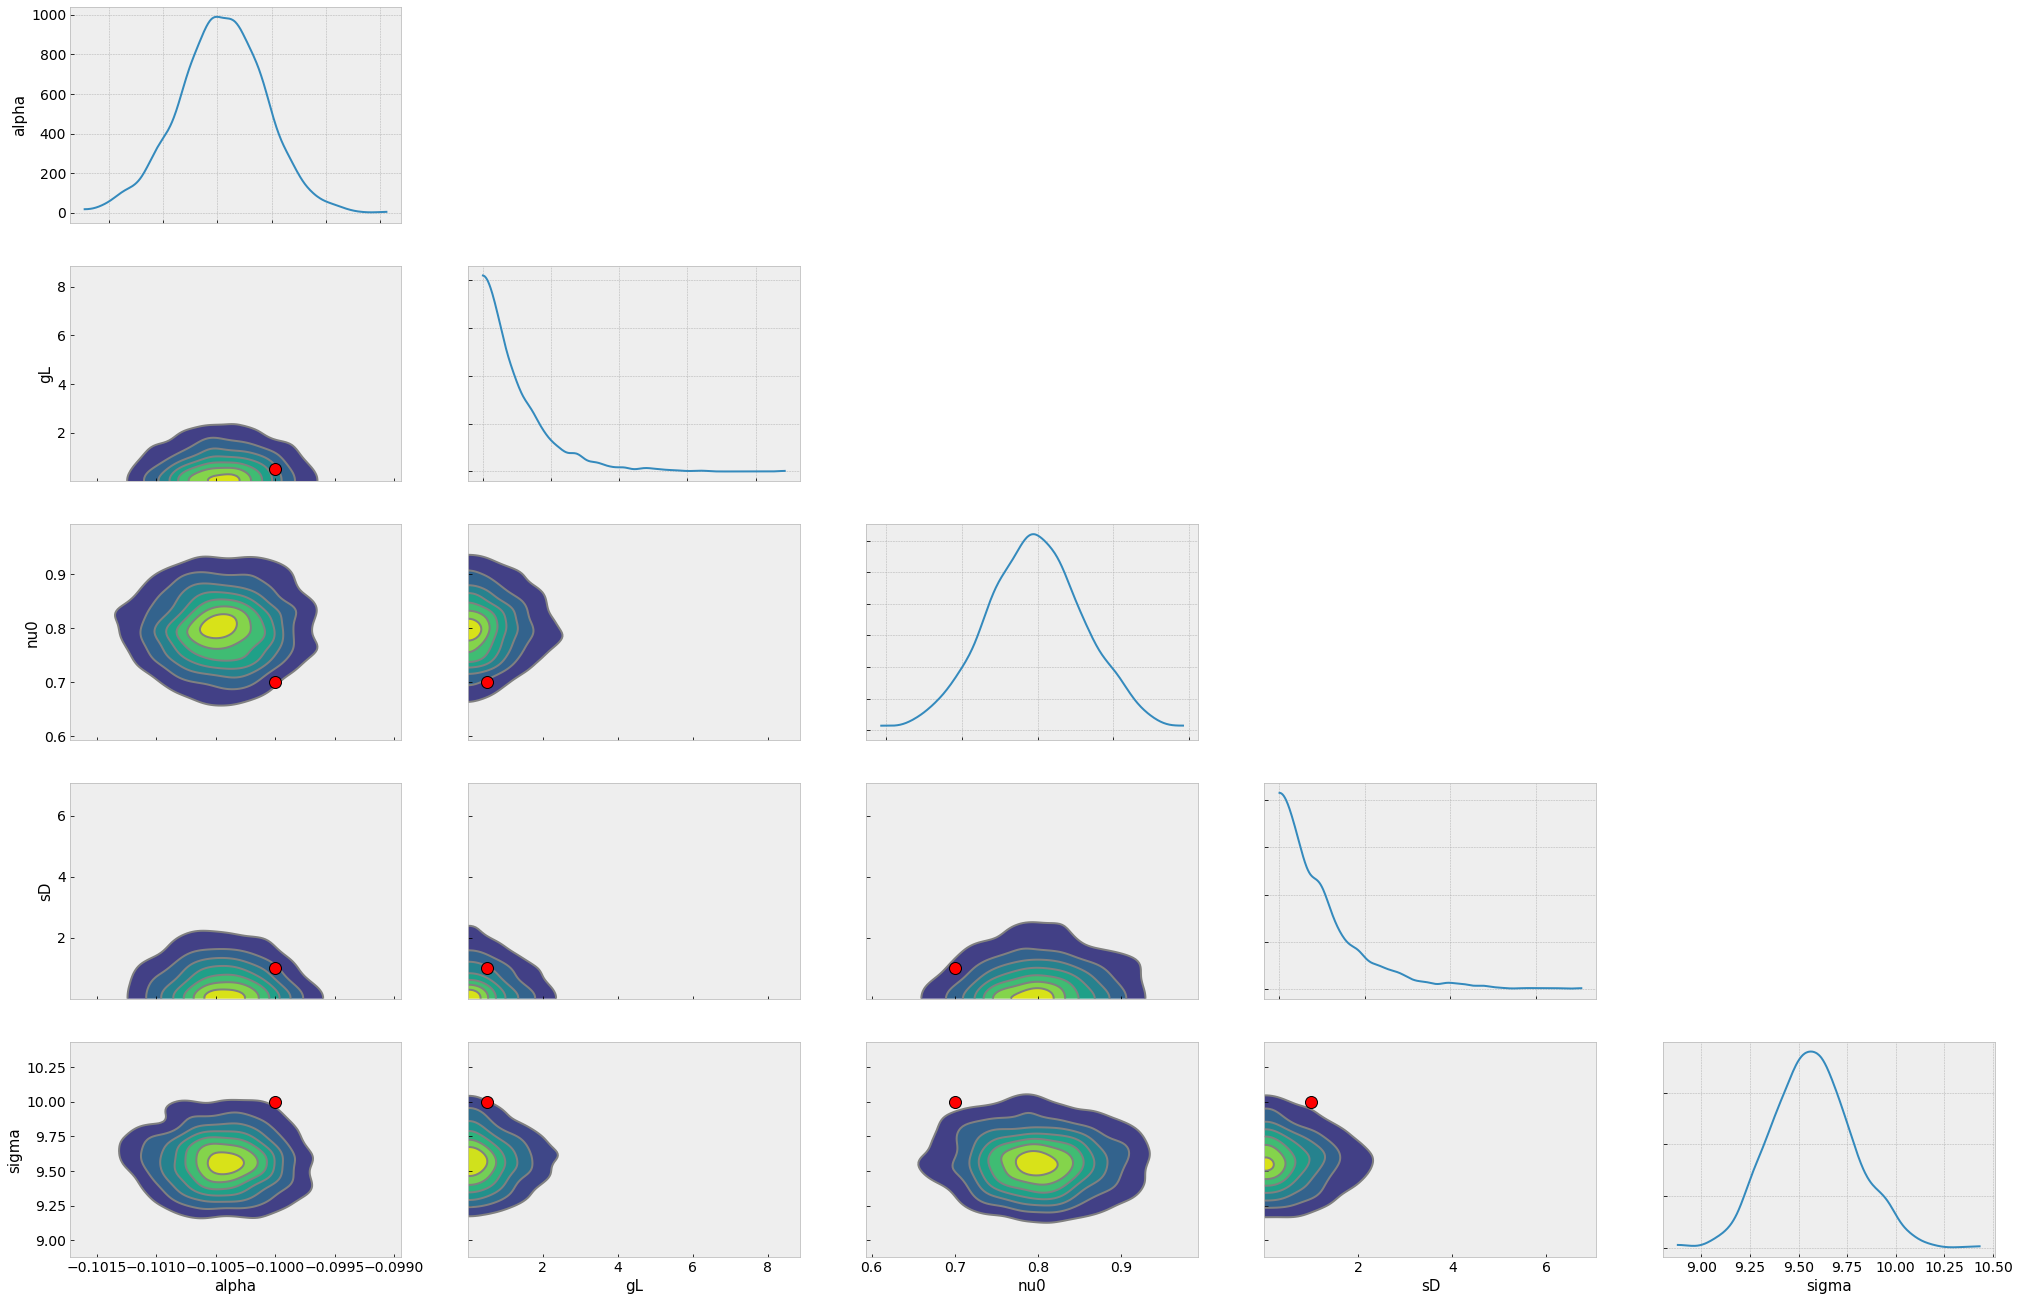

In [36]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [39]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

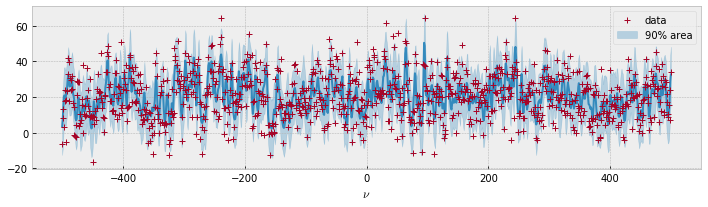

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()

## Layer scan

In [9]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.NP=NP
jaxrt.k=k

In [10]:
numic=0.5
F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
init=[F0,Parr[0],0.7,1.0,0.5]
jaxrt.Tarr=Tarr
%timeit jaxrt.layerscan(init)

2.93 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


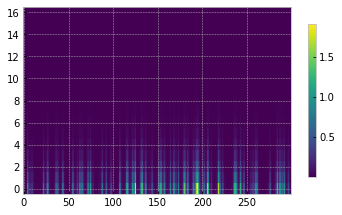

In [11]:
F0=jnp.zeros(len(nuarr))
init=[F0,Parr[0],0.7,1.0,0.5]
FP,tauarr=scan(jaxrt.add_layer,init,Tarr.T,NP)

fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow(tauarr)
plt.colorbar(c,shrink=0.7)
ax.set_aspect(0.7/ax.get_data_ratio())
plt.gca().invert_yaxis()

In [12]:
from jax import grad
F0=jnp.zeros(len(nuarr))
#F0=0.0
init=[F0,Parr[0],0.7,1.0,0.5]
#scan(add_layer,init,Tarr,NP)

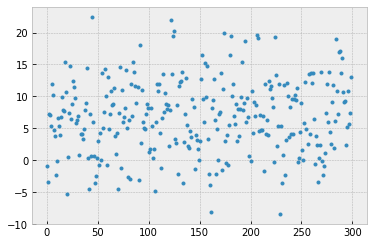

In [16]:
@jit
def g(xs):
    """
    Params: 
      xs: free parameters
    """
    Tarr=xs
    numic=0.5
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #F0=0.0
    init=[F0,Parr[0],0.7,1.0,0.5]
    FP,null=scan(jaxrt.add_layer,init,Tarr,NP)
    return FP[0]*3.e4

sigin=5.0
data=g(Tarr)+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [17]:
#jaxrt.Tarr=Tarr

#probabilistic model using numpyro
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    numic=0.5
    nuarr=nu
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    init=[F0,Parr[0],nu0,sD,gL]
    jaxrt.Tarr=Tarr
    mu=jaxrt.layerscan(init)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [13:50<00:00,  2.94it/s, 15 steps of size 3.07e-01. acc. prob=0.90]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        gL      0.76      0.37      0.75      0.18      1.38    665.32      1.00
       nu0      0.47      0.21      0.48      0.13      0.81   1239.00      1.00
        sD      1.04      0.43      1.05      0.24      1.65    645.96      1.00
     sigma      4.88      0.20      4.87      4.55      5.19   1361.18      1.00

Number of divergences: 57


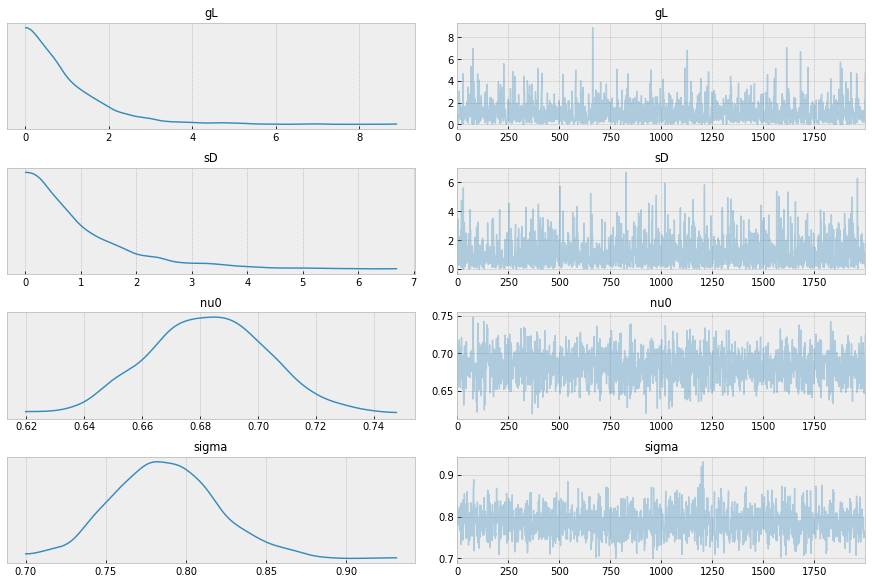

In [22]:
import arviz
arviz.plot_trace(mcmc, var_names=["gL", "sD","nu0","sigma"])
plt.show()

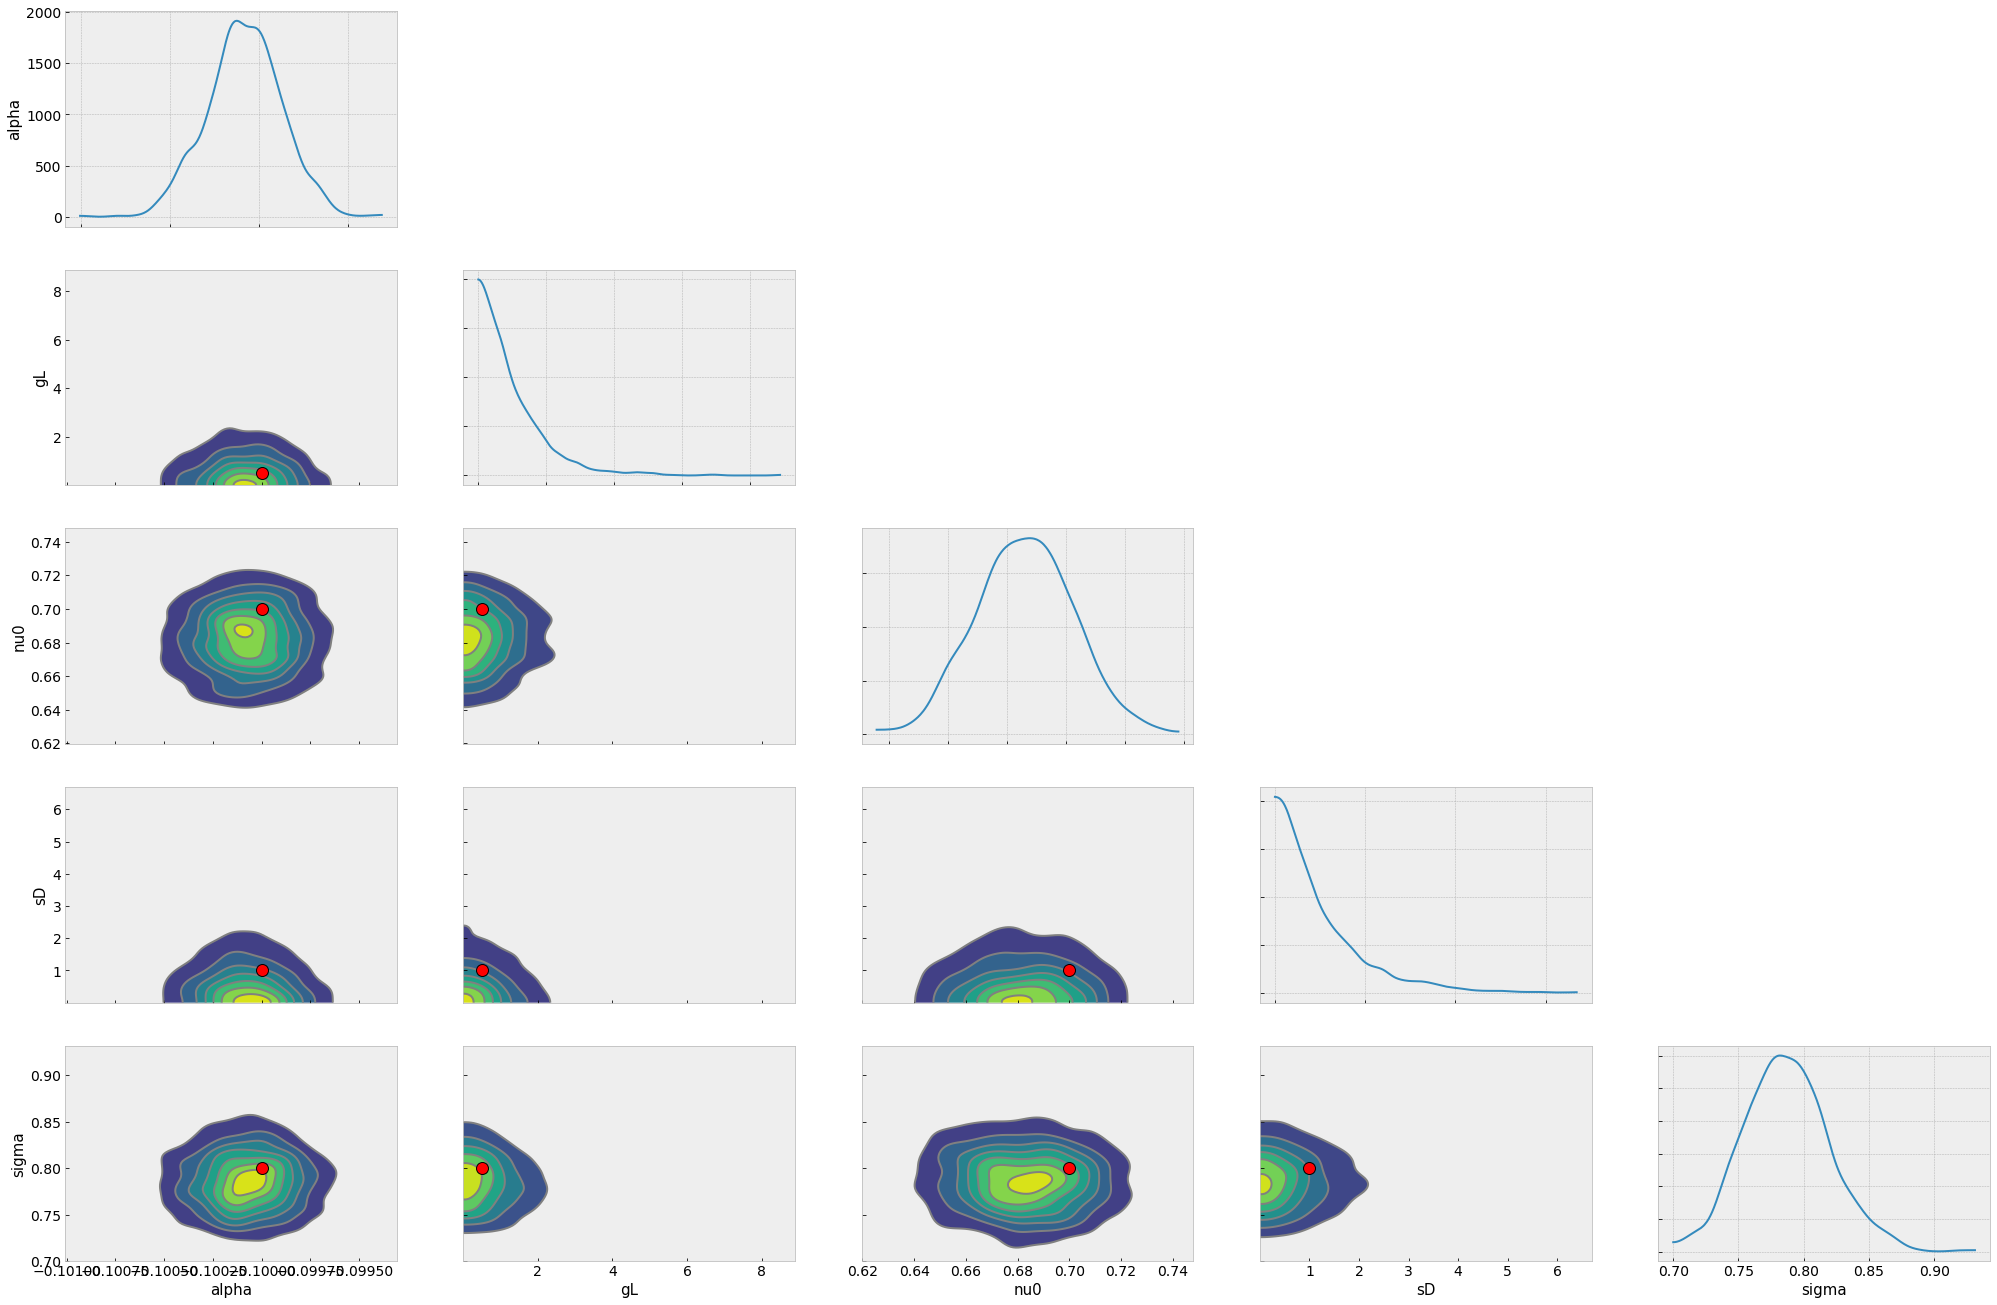

In [24]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [25]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

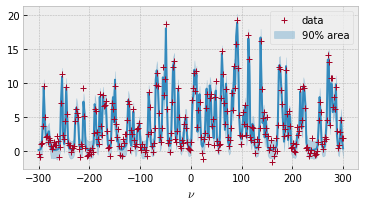

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()